Valores faltantes en el dataset: 0
Características categóricas detectadas: ['tipo_Apartamento', 'tipo_Casa', 'tipo_Chalet adosado', 'color_Amarelo', 'color_Azul', 'color_Branco', 'color_Negro', 'color_Verde', 'color_Vermello', 'tipo_Apartamento.1', 'tipo_Casa.1', 'tipo_Chalet adosado.1', 'color_Amarelo.1', 'color_Azul.1', 'color_Branco.1', 'color_Negro.1', 'color_Verde.1', 'color_Vermello.1']
Forma del dataset: (20000, 47)
Features incluidas: ['superficie_interior_m2', 'superficie_exterior_m2', 'numero_habitacions', 'numero_banos', 'ano_construccion', 'lonxitude', 'latitude', 'temperatura_media_mes_construccion', 'distancia_centro_km', 'distancia_escola_km', 'indice_criminalidade', 'numero_arboles_xardin', 'edad_vivienda', 'superficie_por_habitacion', 'superficie_total', 'ratio_interior_exterior', 'densidad_banos', 'densidad_habitaciones', 'dist_coruna', 'dist_vigo', 'dist_santiago', 'calidad_edad', 'banos_por_habitacion', 'orientacion_valor', 'eficiencia_valor', 'calidade_valor', 'tra

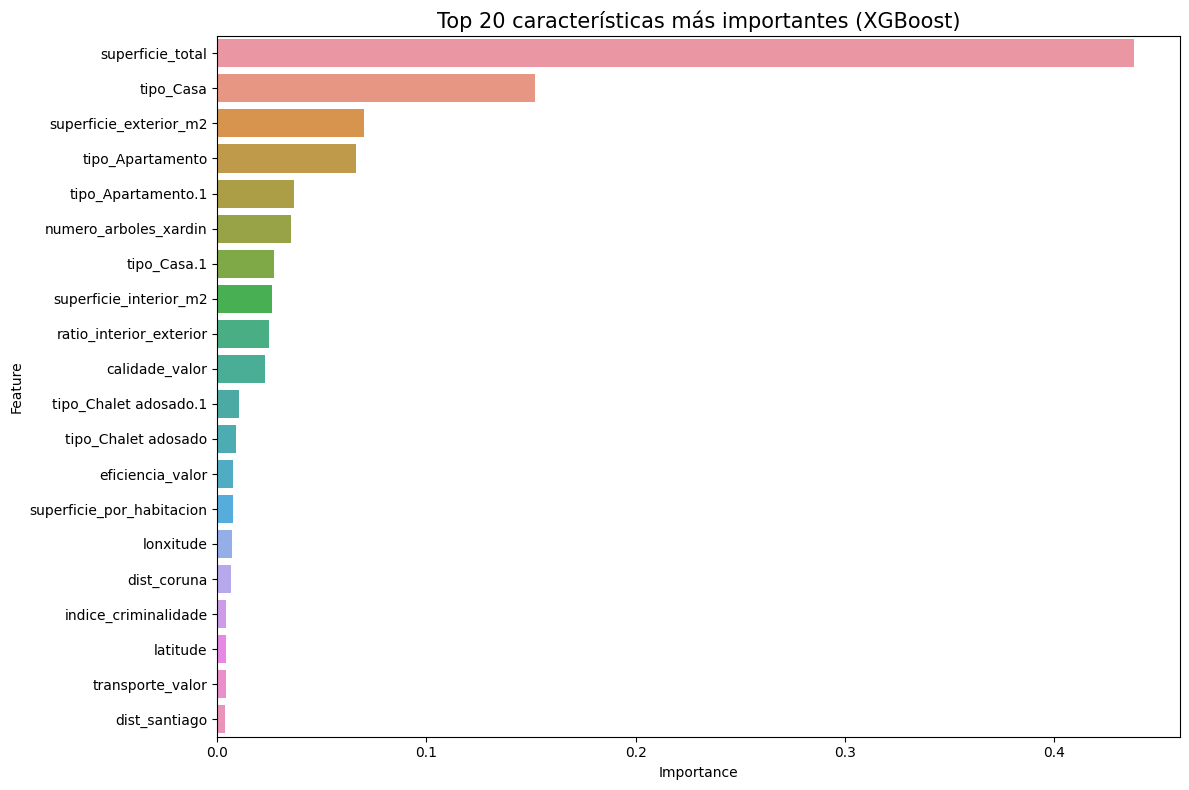

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Create directory for results
os.makedirs('models', exist_ok=True)
os.makedirs('results_xgboost', exist_ok=True)

# Set visualization parameters
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("viridis")

# Function to load and prepare data
def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Valores faltantes en el dataset: {df.isnull().sum().sum()}")
    
    # Identify categorical features
    categorical_features = []
    for col in df.columns:
        if df[col].dtype == 'object' or col in ['tipo_edificacion', 'calidade_materiais', 
                                               'cor_favorita_propietario', 'acceso_transporte_publico',
                                               'orientacion', 'eficiencia_enerxetica'] or 'tipo_' in col or 'color_' in col:
            categorical_features.append(col)
    
    print(f"Características categóricas detectadas: {categorical_features}")
    
    # Separate features and target
    X = df.drop(['prezo_euros', 'id'], axis=1, errors='ignore')
    y = df['prezo_euros']
    
    print(f"Forma del dataset: {df.shape}")
    print(f"Features incluidas: {X.columns.tolist()}")
    
    return X, y, categorical_features

# Function to train XGBoost model
def train_xgboost_model(X, y, random_state=42):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=random_state
    )
    
    print("\n=== Entrenando modelo XGBoost ===")
    
    # Initial hyperparameters
    param_grid = {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2],
        'objective': ['reg:squarederror']
    }
    
    # Simplified version for faster execution
    simple_param_grid = {
        'n_estimators': [200, 500],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'objective': ['reg:squarederror']
    }
    
    # Create model
    model = XGBRegressor(random_state=random_state)
    
    # Grid search with cross-validation
    print("Realizando búsqueda de hiperparámetros con GridSearchCV...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=simple_param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Best parameters
    print(f"Mejores hiperparámetros: {grid_search.best_params_}")
    
    # Train final model
    best_model = XGBRegressor(**grid_search.best_params_, random_state=random_state)
    best_model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Métricas del modelo XGBoost:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.4f}")
    
    # Feature importance
    feature_importance = best_model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 características más importantes (XGBoost)', fontsize=15)
    plt.tight_layout()
    plt.savefig('results_xgboost/xgboost_feature_importance.png')
    
    print("\nAnálisis de características completado - Ver 'results_xgboost/xgboost_feature_importance.png'")
    
    return best_model

# Main execution
if __name__ == "__main__":
    start_time = time.time()
    
    # Load data
    X, y, cat_features = load_data('train_processed.csv')
    
    # Train XGBoost model
    model = train_xgboost_model(X, y)
    
    # Save model
    model.save_model('models/stacking_xgboost_model.json')
    print("\nModelo guardado como 'models/xgboost_model.json'")
    
    end_time = time.time()
    print(f"Tiempo total de ejecución: {end_time - start_time:.2f} segundos")